In [1]:
%load_ext nb_black
# add pathway to folders 1 level higher (i.e., to configs)
import os
import sys

sys.path.append("../")

import copy
import joblib
import numpy as np

import regionmask
from cartopy.io import shapereader
import geopandas


# plotting
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs

# import MESMER tools
from mesmer.io import load_cmipng, load_regs_ls_wgt_lon_lat, load_obs
from mesmer.utils import extract_land, convert_dict_to_arr

# load in configurations used in this script
import configs.config_major_emitters_cmip5ng_rcpall_default as cfg

<IPython.core.display.Javascript object>

In [2]:
print("Get config information sorted")

#directories
dir_magicc = cfg.dir_magicc
dir_median = cfg.dir_stats_median
dir_probhy = cfg.dir_stats_probhy
dir_samples = cfg.dir_sample_emulations
dir_plots = cfg.dir_plots

# rest of config info
scens = cfg.scens_magicc_ref + cfg.scens_magicc_m + cfg.scens_magicc_pc
scens_ref_m = cfg.scens_magicc_ref + cfg.scens_magicc_m
scens_ref_pc = cfg.scens_magicc_ref + cfg.scens_magicc_pc
scens_ref_m_KYGHG = scens_ref_m + cfg.scens_magicc_m_se
print('Scenarios considered here',scens)

ps = cfg.ps
print('Percentiles',ps)

thres_levels_median = [0.5,1,1.5,2,2.5]
print('Threshold levels median:',thres_levels_median)
thres_levels_probhy = [5,25,50,75,95]
print('Threshold levels probability extreme hot year:',thres_levels_probhy)


Get config information sorted
Scenarios considered here ['h-NDC', 'm_top5_Paris', 'm_top5_IPCC', 'pc_IND_Paris', 'pc_EU_Paris', 'pc_CHN_Paris', 'pc_RUS_Paris', 'pc_US_Paris', 'pc_IND_IPCC', 'pc_EU_IPCC', 'pc_CHN_IPCC', 'pc_RUS_IPCC', 'pc_US_IPCC']
Percentiles [5, 17, 50, 83, 95]
Threshold levels median: [0.5, 1, 1.5, 2, 2.5]
Threshold levels probability extreme hot year: [5, 25, 50, 75, 95]


<IPython.core.display.Javascript object>

In [3]:
print("Load in the global forced warming percentiles")
perc_Tglob_gt = joblib.load(dir_median + "perc_median_forced_global.pkl")

print(
    "Load in the grid-cell-level percentiles of medians and probabilities of extreme hot years"
)
perc_median = joblib.load(dir_median + "perc_median_grid_point_level.pkl")
perc_probhy = joblib.load(dir_probhy + "perc_probhy_grid_point_level.pkl")


print(
    "Load in information from a single ESM to obtain region and land mask information"
)
# TODO: improve MESMER library to no longer depend on ESM run for region / land mask infos

# load in tas with global coverage
tas_g = {}
for esm in ["CanESM2"]:
    print(esm)
    tas_g_dict = {}
    for scen in ["h-rcp85"]:
        tas_g_dict[scen], _, lon, lat, _ = load_cmipng("tas", esm, scen, cfg)
    tas_g[esm] = convert_dict_to_arr(tas_g_dict)

# load in the constant files
reg_dict, ls, wgt_g, lon, lat = load_regs_ls_wgt_lon_lat(cfg.reg_type, lon, lat)

# extract land
tas, reg_dict, ls = extract_land(
    tas_g, reg_dict, wgt_g, ls, threshold_land=cfg.threshold_land
)

print(
    "List the countries which are countries according to regionmask but do not have a land grid point in my setup"
)
nr_c_no_l = 0
for i in np.arange(len(reg_dict["abbrevs"])):
    if len(np.unique(reg_dict["gps_l"][i])) == 1:
        nr_c_no_l += 1
        print(nr_c_no_l, reg_dict["names"][i])

nr_c_tot = len(reg_dict["abbrevs"])
print("# countries according to regionmask:", nr_c_tot)
nr_c_l = len(reg_dict["abbrevs"]) - nr_c_no_l
print("# countries where our grid contains land grid points:", nr_c_l)

print(
    "Compute country-level averages of medians and probabilities of extreme hot years"
)
# (country-level average = typical grid-cell-level behaviour for each country)
perc_median_c = {}
perc_probhy_c = {}

for scen in scens:
    nr_ts, nr_gps = perc_median[scen][ps[0]].shape
    # shape identical for each percentile
    perc_median_c[scen] = {}
    perc_probhy_c[scen] = {}

    for p in ps:
        perc_median_c[scen][p] = np.zeros([nr_ts, nr_c_tot])
        perc_probhy_c[scen][p] = np.zeros([nr_ts, nr_c_tot])

        for c in np.arange(nr_c_tot):
            wgt_c = reg_dict["wgt_gps_l"][c]
            if wgt_c.sum() > 0:
                perc_median_c[scen][p][:, c] = np.average(
                    perc_median[scen][p], weights=wgt_c, axis=1
                )
                perc_probhy_c[scen][p][:, c] = np.average(
                    perc_probhy[scen][p], weights=wgt_c, axis=1
                )

            else:
                # if no land grid point availble, set value to 0
                perc_median_c[scen][p][:, c] = 0
                perc_probhy_c[scen][p][:, c] = 0


print("Compute percentage of countries over given median and probability thresholds")
pct_median_c_over = {}
for thres in thres_levels_median:
    pct_median_c_over[thres] = {}
    for scen in scens:
        pct_median_c_over[thres][scen] = {}
        for p in ps:
            nr_c_over = np.sum(perc_median_c[scen][p] > thres, axis=1)
            pct_median_c_over[thres][scen][p] = nr_c_over / nr_c_l * 100

pct_probhy_c_over = {}
for thres in thres_levels_probhy:
    pct_probhy_c_over[thres] = {}
    for scen in scens:
        pct_probhy_c_over[thres][scen] = {}
        for p in ps:
            nr_c_over = np.sum(perc_probhy_c[scen][p] > thres, axis=1)
            pct_probhy_c_over[thres][scen][p] = nr_c_over / nr_c_l * 100

Load in the global forced warming percentiles
Load in the grid-cell-level percentiles of medians and probabilities of extreme hot years
Load in information from a single ESM to obtain region and land mask information
CanESM2
List the countries which are countries according to regionmask but do not have a land grid point in my setup
1 Fiji
2 Bahamas
3 Falkland Is.
4 Fr. S. Antarctic Lands
5 Timor-Leste
6 Puerto Rico
7 Jamaica
8 Vanuatu
9 New Caledonia
10 Solomon Is.
11 Antarctica
12 Trinidad and Tobago
# countries according to regionmask: 177
# countries where our grid contains land grid points: 165
Compute country-level averages of medians and probabilities of extreme hot years
Compute percentage of countries over given median and probability thresholds


<IPython.core.display.Javascript object>

In [4]:
print('Deal with top five regional information (averages + masking)')

print('derive weights regions on grid')
eu27_names=['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece', 
            'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 
            'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia', 
            'Finland', 'Sweden', 'N. Cyprus'] 
    # Malta not in the list of countries (& no land gp)
    # Cyprus split into N. Cyprus & Cyprus (but located at correct place)
idxs_eu27=np.zeros(len(eu27_names),dtype=int)
for i in np.arange(len(eu27_names)):
    idxs_eu27[i]=int(reg_dict['full'].map_keys(eu27_names[i]))

idx_top5_rest={}
idx_top5_rest['CHN']=int(reg_dict['full'].map_keys('China'))
idx_top5_rest['US']=int(reg_dict['full'].map_keys('US'))
idx_top5_rest['IND']=int(reg_dict['full'].map_keys('IND'))
idx_top5_rest['RUS']=int(reg_dict['full'].map_keys('RUS'))


wgt_gps_l={}
wgt_gps_l['EU']=np.zeros(nr_gps)

for idx_eu27 in idxs_eu27:
    wgt_gps_l['EU']+=reg_dict['wgt_gps_l'][idx_eu27]
    
for e in ['CHN','US','IND','RUS']:
    wgt_gps_l[e]=reg_dict['wgt_gps_l'][idx_top5_rest[e]]
    
    
print('create shapefile for EU27 region')
# read natural_earth dataframe
resolution="50m"
category="cultural"
name="admin_0_countries"
shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename, encoding="utf8")
# select countries
sel = df.NAME.isin(eu27_names)
df_EURO = df.loc[sel]
# create one MultiPolygon
multipoly = df_EURO.unary_union
# create a region
eu27 = regionmask.Regions(
    [df_EURO.unary_union],
    names="EU-27",
    abbrevs="EU",
    name="EU-27 based on naturalearth"
)



Deal with top five regional information (averages + masking)
derive weights regions on grid
create shapefile for EU27 region


<IPython.core.display.Javascript object>

## Modelling setup figure 1 and numbers

In [5]:
emitters = cfg.emitters_pc
title_e = cfg.title_e_pc
emitters_abs = cfg.emitters_abs
scens_m_se = cfg.scens_magicc_m_se
print("Emitters considered here", emitters)

Emitters considered here ['IND', 'EU', 'CHN', 'RUS', 'US']


<IPython.core.display.Javascript object>

In [6]:
print('Prepare time and Tglob data')

time = np.arange(cfg.time_emus["start"],cfg.time_emus["end"]+1)

# put the indices where the computations should start
idx_time={}

# scens_magicc_ref
idx_time['h-NDC']=0

# scens_magicc_m
idx_time['m_top5_Paris']=np.where(time==2016)[0][0]
idx_time['m_top5_IPCC']=np.where(time==1991)[0][0]


Prepare time and Tglob data


<IPython.core.display.Javascript object>

In [7]:
print("Prepare the Kyoto greenhouse gas data")
KYGHGem = joblib.load(dir_magicc + "KYOTOGHGem_all_scens.pkl")

# Kyotot GHG emissions single emitter
KYGHGem_se = {}
for period in ["Paris", "IPCC"]:
    for e in emitters:
        KYGHGem_se[e + "_" + period] = (
            KYGHGem["h-NDC"] - KYGHGem["m_" + e + "_" + period]
        )

Prepare the Kyoto greenhouse gas data


<IPython.core.display.Javascript object>

In [8]:
print('Setup plotting config')
col={}
col['h-NDC']='#d7191c'
col['m_top5_Paris']='#ffab0f'
col['m_top5_IPCC']='#2c7bb6'
col['CHN']='#525252'
col['US']='#737373'
col['EU']='#969696'
col['IND']='#bdbdbd'
col['RUS']='#d9d9d9'

label_reg={}
for e,title in zip(emitters,title_e):
    label_reg[e]=title

label_scen={}
label_scen['h-NDC']='Historical and NDC'
label_scen['m_top5_Paris']='Without top five since Paris'
label_scen['m_top5_IPCC']='Without top five since IPCC'


Setup plotting config


<IPython.core.display.Javascript object>

Plot Kyoto greenhouse gas emissions


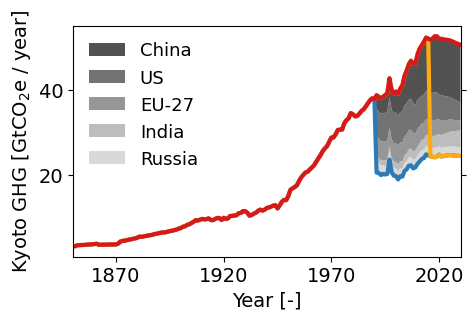

<IPython.core.display.Javascript object>

In [9]:
print("Plot Kyoto greenhouse gas emissions")

fig = plt.figure(figsize=(5, 3))
plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"mathtext.default": "regular"})
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.0)
plt.subplot(grid[0, 0])

KYGHG_tmp = copy.deepcopy(KYGHGem["m_top5_IPCC"])
h = {}
for e in emitters_abs:
    h[e] = plt.fill_between(
        time,
        KYGHG_tmp,
        KYGHG_tmp + KYGHGem_se[e + "_IPCC"],
        facecolor=col[e],
        label=label_reg[e],
    )
    KYGHG_tmp += KYGHGem_se[e + "_IPCC"]

for scen in scens_ref_m[::-1]:
    plt.plot(time, KYGHGem[scen], color=col[scen], lw=3)

ax = plt.gca()
ax.tick_params(right=True)
plt.xticks(np.arange(1870, 2040, 50))
plt.xlim([time[0], time[-1]])
plt.xlabel("Year [-]")
plt.ylabel("Kyoto GHG [GtCO$_2$e / year]")
plt.legend(
    handles=[h["CHN"], h["US"], h["EU"], h["IND"], h["RUS"]], fontsize=13, frameon=False
)

plt.savefig(dir_plots + "fig1/ts_KYOTOGHGem.png", dpi=200, bbox_inches="tight")
plt.savefig(dir_plots + "fig1/ts_KYOTOGHGem.pdf", dpi=200, bbox_inches="tight")

In [10]:
print("cumulative Kyoto GHG emissions by 2030:", np.cumsum(KYGHGem["h-NDC"])[-1])

cum_KYGHG_since_Paris = np.cumsum(KYGHGem["h-NDC"][idx_time["m_top5_Paris"] :])[-1]
print("cumulative Kyoto GHG emissions by 2030 since Paris:", cum_KYGHG_since_Paris)
cum_KYGHG_restworld_since_Paris = np.cumsum(
    KYGHGem["m_top5_Paris"][idx_time["m_top5_Paris"] :]
)[-1]
print(
    "Percentage cum Kyoto GHG emissions by 2030 since Paris of top5:",
    (100 - cum_KYGHG_restworld_since_Paris / cum_KYGHG_since_Paris * 100),
)


cum_KYGHG_since_IPCC = np.cumsum(KYGHGem["h-NDC"][idx_time["m_top5_IPCC"] :])[-1]
cum_KYGHG_restworld_since_IPCC = np.cumsum(
    KYGHGem["m_top5_IPCC"][idx_time["m_top5_IPCC"] :]
)[-1]
print("cumulative Kyoto GHG emissions by 2030 since IPCC:", cum_KYGHG_since_IPCC)
print(
    "Percentage cum Kyoto GHG emissions by 2030 since IPCC of top5:",
    (100 - cum_KYGHG_restworld_since_IPCC / cum_KYGHG_since_IPCC * 100),
)

cumulative Kyoto GHG emissions by 2030: 3779.1843
cumulative Kyoto GHG emissions by 2030 since Paris: 776.58276
Percentage cum Kyoto GHG emissions by 2030 since Paris of top5: 52.60746479034424
cumulative Kyoto GHG emissions by 2030 since IPCC: 1869.3817
Percentage cum Kyoto GHG emissions by 2030 since IPCC of top5: 51.52142345905304


<IPython.core.display.Javascript object>

Plot forced global warming


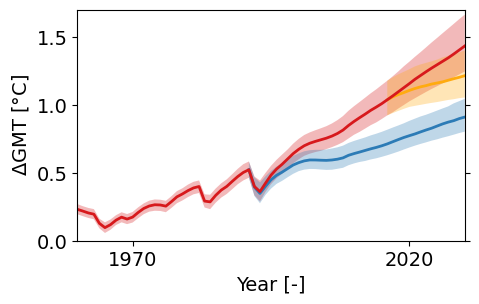

<IPython.core.display.Javascript object>

In [11]:
print("Plot forced global warming")

fig = plt.figure(figsize=(5, 3))
plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"mathtext.default": "regular"})
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.0)
plt.subplot(grid[0, 0])


for scen in scens_ref_m:
    plt.fill_between(
        time[idx_time[scen] :],
        perc_Tglob_gt[scen][17],
        perc_Tglob_gt[scen][83],
        facecolor=col[scen],
        alpha=0.3,
    )

for scen in scens_ref_m[::-1]:
    plt.plot(time[idx_time[scen] :], perc_Tglob_gt[scen][50], color=col[scen], lw=2)

ax = plt.gca()
ax.tick_params(right=True)
plt.xticks(np.arange(1870, 2040, 50))
plt.yticks([0, 0.5, 1, 1.5])
plt.xlabel("Year [-]")
plt.ylabel("$\Delta GMT$ [°C]")
plt.xlim([1960, time[-1]])
plt.ylim([0, 1.7])
plt.savefig(dir_plots + "fig1/ts_Tglob.png", dpi=200, bbox_inches="tight")
plt.savefig(dir_plots + "fig1/ts_Tglob.pdf", dpi=200, bbox_inches="tight")

In [12]:
print("expected forced warming in NDC pathway by 2030:", perc_Tglob_gt["h-NDC"][50][-1])
print(
    "66% likely range:", perc_Tglob_gt["h-NDC"][17][-1], perc_Tglob_gt["h-NDC"][83][-1]
)

expected forced warming in NDC pathway by 2030: 1.433189570903778
66% likely range: 1.2457341349124909 1.663514199256897


<IPython.core.display.Javascript object>

Plot legend


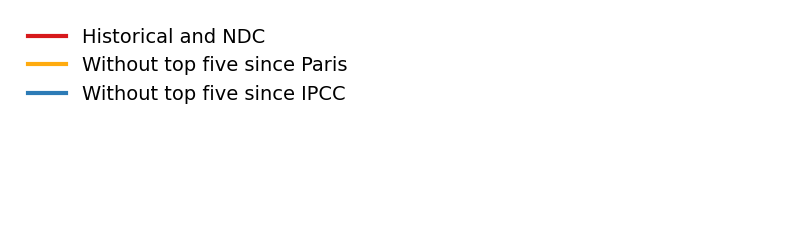

<IPython.core.display.Javascript object>

In [13]:

print('Plot legend')
fig=plt.figure(figsize=(5*2, 3))
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'mathtext.default':'regular'})
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.)

for scen in scens_ref_m:
    h[scen]=[Line2D([0], [0], color=col[scen],lw=3,label=label_scen[scen])][0]
    
plt.legend(handles=[h['h-NDC'],h['m_top5_Paris'],h['m_top5_IPCC']],loc=2,frameon=False)

plt.axis('off')

plt.savefig(dir_plots+'fig1/legend.png' ,dpi=200 ,bbox_inches='tight')
plt.savefig(dir_plots+'fig1/legend.pdf' ,dpi=200 ,bbox_inches='tight')


Plot map of median probability of extreme hot year in 2030


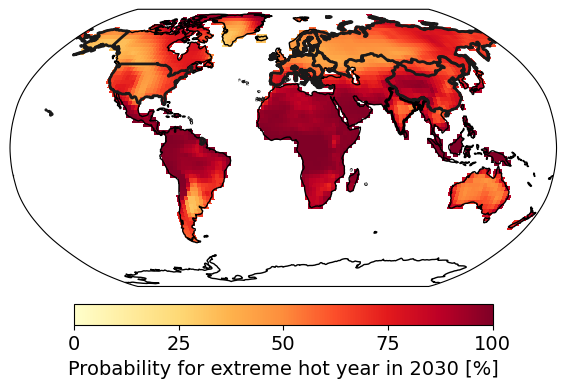

<IPython.core.display.Javascript object>

In [14]:
print("Plot map of median probability of extreme hot year in 2030")
fig = plt.figure(figsize=(9, 4.5))
plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"mathtext.default": "regular"})  # regular

y_ma = copy.deepcopy(ls["grid_l_m"])
y_ma[ls["idx_grid_l"]] = perc_probhy["h-NDC"][50][-1]

ax1 = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
ax1.coastlines()
mesh_1 = ax1.pcolormesh(
    lon["e"],
    lat["e"],
    y_ma,
    cmap="YlOrRd",
    vmin=0,
    vmax=100,
    transform=ccrs.PlateCarree(),
    rasterized=True,
)

reg_dict["full"].plot_regions(
    regions=["IND"], ax=ax1, add_label=False, line_kws=dict(lw=2, color="k")
)
# color = 'k' already default. Just leave in there to remember where I could change
reg_dict["full"].plot_regions(
    regions=["RUS"], ax=ax1, add_label=False, line_kws=dict(lw=2)
)
eu27.plot_regions(ax=ax1, add_label=False, line_kws=dict(lw=2))
reg_dict["full"].plot_regions(
    regions=["Switzerland"], ax=ax1, add_label=False, line_kws=dict(lw=2)
)
# to highlight that CH is not part of EU27
reg_dict["full"].plot_regions(
    regions=["US"], ax=ax1, add_label=False, line_kws=dict(lw=2)
)
reg_dict["full"].plot_regions(
    regions=["China"], ax=ax1, add_label=False, line_kws=dict(lw=2)
)

cb = plt.colorbar(
    mesh_1, extend="neither", orientation="horizontal", shrink=0.6, pad=0.05
)
cb.set_label("Probability for extreme hot year in 2030 [%]")
cb.set_ticks([0, 25, 50, 75, 100])


plt.savefig(dir_plots + "fig1/map_median_probhy_2030.png", dpi=200, bbox_inches="tight")
plt.savefig(dir_plots + "fig1/map_median_probhy_2030.pdf", dpi=200, bbox_inches="tight")

In [15]:
print('Regional probability of hot year time series for each major emitter')
reg_probhy = {}
for scen in scens_ref_m:
    reg_probhy[scen] = {}
    for e in emitters:
        reg_probhy[scen][e] = {}
        for p in ps:
            reg_probhy[scen][e][p] = np.average(perc_probhy[scen][p],weights=wgt_gps_l[e],axis=1)


Regional probability of hot year time series for each major emitter


<IPython.core.display.Javascript object>

In [16]:
print("Plot regional probability time series")

for e in emitters:
    fig = plt.figure(figsize=(5, 3))
    plt.rcParams.update({"font.size": 14})
    plt.rcParams.update({"mathtext.default": "regular"})  # regular
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.0)  # create a grid for the subplots
    plt.subplot(grid[0, 0])

    for scen in scens_ref_m:
        plt.fill_between(
            time[idx_time[scen] :],
            reg_probhy[scen][e][17],
            reg_probhy[scen][e][83],
            facecolor=col[scen],
            alpha=0.3,
        )

    for scen in scens_ref_m[::-1]:
        plt.plot(time[idx_time[scen] :], reg_probhy[scen][e][50], color=col[scen], lw=2)

    ax = plt.gca()
    ax.tick_params(right=True)
    plt.xticks(np.arange(1870, 2040, 50))
    plt.ylim([0, 100])
    plt.yticks([0, 25, 50, 75, 100])

    plt.xlim([time[0], time[-1]])
    plt.xlabel("Year [-]")
    plt.ylabel(label_reg[e] + " probability [%]")
    plt.xlim([1960, time[-1]])

    plt.savefig(
        dir_plots + "fig1/ts_probhy_" + e + ".png", dpi=200, bbox_inches="tight"
    )
    plt.savefig(
        dir_plots + "fig1/ts_probhy_" + e + ".pdf", dpi=200, bbox_inches="tight"
    )
    plt.close()

Plot regional probability time series


<IPython.core.display.Javascript object>

## Country-level warming and extremes figure 2 and numbers

In [17]:
print("Scenarios considered here:", scens_ref_m)

print("Derive arrays for 2030 median median and probability extreme hot year maps")
median_median_c_map_2030 = {}  # country-level median map in the year 2030
median_probhy_c_map_2030 = {}  # country-level median map in the year 2030

for scen in scens_ref_m:
    median_median_c_map_2030[scen] = np.zeros(nr_gps)
    median_probhy_c_map_2030[scen] = np.zeros(nr_gps)

    for gp in np.arange(nr_gps):
        median_median_c_map_2030[scen][gp] = np.average(
            perc_median_c[scen][50][-1], weights=reg_dict["wgt_gps_l"][:, gp]
        )
        median_probhy_c_map_2030[scen][gp] = np.average(
            perc_probhy_c[scen][50][-1], weights=reg_dict["wgt_gps_l"][:, gp]
        )
        # at every gp average across weights associated with each country

print("Derive arrays for % countries above threshold vs forced warming plot")


# concat all scenarios for the visualization

# median forced global warming
median_Tglob_gt_all_scens = np.concatenate(
    [
        perc_Tglob_gt[scens_ref_m[0]][50],
        perc_Tglob_gt[scens_ref_m[1]][50],
        perc_Tglob_gt[scens_ref_m[2]][50],
    ]
)

# percentage of countries above threshold median value
pct_median_c_over_all_scens = {}
for thres in thres_levels_median:
    pct_median_c_over_all_scens[thres] = {}
    for p in ps:
        pct_median_c_over_all_scens[thres][p] = np.concatenate(
            [
                pct_median_c_over[thres][scens_ref_m[0]][p],
                pct_median_c_over[thres][scens_ref_m[1]][p],
                pct_median_c_over[thres][scens_ref_m[2]][p],
            ]
        )

# percentage of countries above threshold median value
pct_probhy_c_over_all_scens = {}
for thres in thres_levels_probhy:
    pct_probhy_c_over_all_scens[thres] = {}
    for p in ps:
        pct_probhy_c_over_all_scens[thres][p] = np.concatenate(
            [
                pct_probhy_c_over[thres][scens_ref_m[0]][p],
                pct_probhy_c_over[thres][scens_ref_m[1]][p],
                pct_probhy_c_over[thres][scens_ref_m[2]][p],
            ]
        )


# find indices that sort concatenated Tglob to be monotonically increasing
idx_sorted = np.argsort(median_Tglob_gt_all_scens)

Scenarios considered here: ['h-NDC', 'm_top5_Paris', 'm_top5_IPCC']
Derive arrays for 2030 median median and probability extreme hot year maps
Derive arrays for % countries above threshold vs forced warming plot


<IPython.core.display.Javascript object>

In [18]:
print("Set up plotting configs")

# colormaps
mymap_median = cm.get_cmap("YlOrRd")
vmax_median = 2.5
vmin_median = 0.0
norm_median = mcolors.Normalize(vmin=vmin_median, vmax=vmax_median)

mymap_probhy = cm.get_cmap("YlOrRd")
vmax_probhy = 100
vmin_probhy = 0
norm_probhy = mcolors.Normalize(vmin=vmin_probhy, vmax=vmax_probhy)

# labels
lab_thres_median = {}
for thres in thres_levels_median:
    lab_thres_median[thres] = f"{thres:.1f} °C"

lab_thres_probhy = {}
for thres in thres_levels_probhy:
    lab_thres_probhy[thres] = f"{thres:.0f} %"

Set up plotting configs


<IPython.core.display.Javascript object>

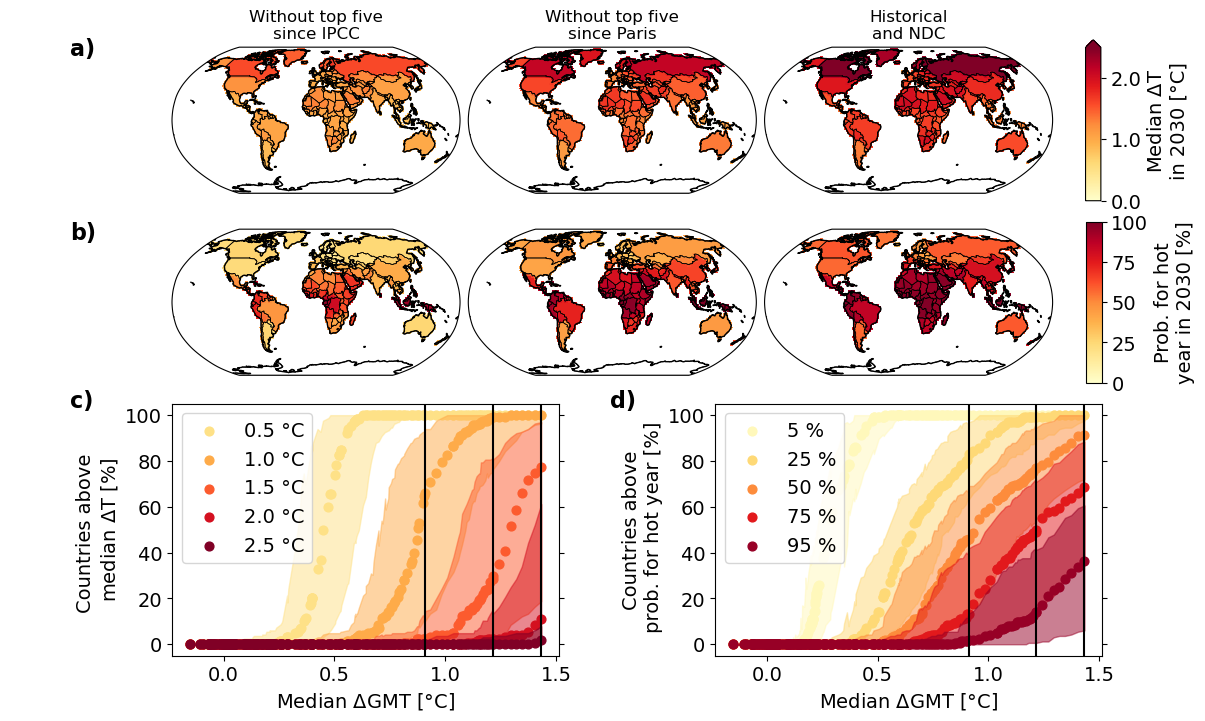

<IPython.core.display.Javascript object>

In [19]:
fig=plt.figure(figsize=(12, 6*2-4))
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'mathtext.default':'regular'}) #regular 
fs_leg=12
fs_let=16

grid = plt.GridSpec(7, 3*6+1, wspace=0.2, hspace=0.3) # create a grid for the subplots


ax0 = plt.subplot(grid[0:2,0:6], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_median_c_map_2030['m_top5_IPCC']
ax0.coastlines()
mesh_1=ax0.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_median,vmin=vmin_median,vmax=vmax_median)
reg_dict['full'].plot_regions(ax=ax0,add_label=False,line_kws=dict(lw=0.5,color='k'))
plt.title('Without top five\nsince IPCC',fontsize=fs_leg)


ax1 = plt.subplot(grid[0:2,6:12], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_median_c_map_2030['m_top5_Paris']
ax1.coastlines()
mesh_1=ax1.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_median,vmin=vmin_median,vmax=vmax_median)
reg_dict['full'].plot_regions(ax=ax1,add_label=False,line_kws=dict(lw=0.5,color='k'))
plt.title('Without top five\nsince Paris',fontsize=fs_leg)

ax2 = plt.subplot(grid[0:2,12:18], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_median_c_map_2030['h-NDC']
ax2.coastlines()
mesh_1=ax2.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_median,vmin=vmin_median,vmax=vmax_median)
reg_dict['full'].plot_regions(ax=ax2,add_label=False,line_kws=dict(lw=0.5,color='k'))
plt.title('Historical\nand NDC',fontsize=fs_leg)

ax3=plt.subplot(grid[0:2,18])
cbar=plt.colorbar(mesh_1,extend='max',aspect=10,fraction=0.4)
cbar.set_ticks([0.,1.0,2.0])
cbar.set_ticklabels(['0.0','1.0','2.0'])
cbar.set_label('Median $\Delta$T\nin 2030 [°C]')
plt.axis('off')


ax0 = plt.subplot(grid[2:4,0:6], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_probhy_c_map_2030['m_top5_IPCC']
ax0.coastlines()
mesh_1=ax0.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_probhy,vmin=vmin_probhy,vmax=vmax_probhy)
reg_dict['full'].plot_regions(ax=ax0,add_label=False,line_kws=dict(lw=0.5,color='k'))


ax1 = plt.subplot(grid[2:4,6:12], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_probhy_c_map_2030['m_top5_Paris']
ax1.coastlines()
mesh_1=ax1.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_probhy,vmin=vmin_probhy,vmax=vmax_probhy)
reg_dict['full'].plot_regions(ax=ax1,add_label=False,line_kws=dict(lw=0.5,color='k'))


ax2 = plt.subplot(grid[2:4,12:18], projection=ccrs.Robinson(central_longitude=0))
y_ma=copy.deepcopy(ls['grid_l_m'])
y_ma[ls['idx_grid_l']]=median_probhy_c_map_2030['h-NDC']
ax2.coastlines()
mesh_1=ax2.pcolormesh(lon['e'], lat['e'],y_ma,transform=ccrs.PlateCarree(),rasterized=True,cmap=mymap_probhy,vmin=vmin_probhy,vmax=vmax_probhy)
reg_dict['full'].plot_regions(ax=ax2,add_label=False,line_kws=dict(lw=0.5,color='k'))

ax3=plt.subplot(grid[2:4,18])
cbar=plt.colorbar(mesh_1,extend='neither',aspect=10,fraction=0.4)
cbar.set_ticks([0,25,50,75,100])
cbar.set_label('Prob. for hot\nyear in 2030 [%]')
plt.axis('off')

ax3 = plt.subplot(grid[4:7,:8])
for thres in thres_levels_median:    
    plt.fill_between(median_Tglob_gt_all_scens[idx_sorted],pct_median_c_over_all_scens[thres][17][idx_sorted],pct_median_c_over_all_scens[thres][83][idx_sorted],color=mymap_median(norm_median(thres)),alpha=0.5)
    plt.scatter(median_Tglob_gt_all_scens[idx_sorted],pct_median_c_over_all_scens[thres][50][idx_sorted],color=mymap_median(norm_median(thres)),label=lab_thres_median[thres],s=40)
plt.axvline(perc_Tglob_gt['h-NDC'][50][-1],color='k')
plt.axvline(perc_Tglob_gt['m_top5_Paris'][50][-1],color='k')
plt.axvline(perc_Tglob_gt['m_top5_IPCC'][50][-1],color='k')
plt.xlabel('Median $\Delta$GMT [°C]')
plt.ylabel('Countries above \nmedian $\Delta$T [%]')
plt.legend()
ax3.yaxis.set_ticks_position('both')

ax3 = plt.subplot(grid[4:7,11:])
for thres in thres_levels_probhy:    
    plt.fill_between(median_Tglob_gt_all_scens[idx_sorted],pct_probhy_c_over_all_scens[thres][17][idx_sorted],pct_probhy_c_over_all_scens[thres][83][idx_sorted],color=mymap_probhy(norm_probhy(thres)),alpha=0.5)
    plt.scatter(median_Tglob_gt_all_scens[idx_sorted],pct_probhy_c_over_all_scens[thres][50][idx_sorted],color=mymap_probhy(norm_probhy(thres)),label=lab_thres_probhy[thres],s=40)
plt.axvline(perc_Tglob_gt['h-NDC'][50][-1],color='k')
plt.axvline(perc_Tglob_gt['m_top5_Paris'][50][-1],color='k')
plt.axvline(perc_Tglob_gt['m_top5_IPCC'][50][-1],color='k')
plt.ylabel('Countries above\n prob. for hot year [%]')
plt.legend()
ax3.yaxis.set_ticks_position('both');
plt.xlabel('Median $\Delta$GMT [°C]')

plt.axes([-0.01, 0.81, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'a)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.axes([-0.01, 0.58, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'b)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.axes([-0.01, 0.37, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'c)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.axes([0.44, 0.37, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'d)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.savefig(dir_plots+'median_probhy_ref_m.png' ,dpi=200 ,bbox_inches='tight')
plt.savefig(dir_plots+'median_probhy_ref_m_beforecrop.pdf' ,dpi=200 ,bbox_inches='tight')
    # end up with white margins -> use pdfcrop command in linux to "solve" problem


In [20]:
scen = "m_top5_IPCC"
thres = 1.5
print(
    scen,
    ": % countries above " + str(thres) + " °C warming in 2030: median:",
    pct_median_c_over[thres][scen][50][-1],
    "66% likely range:",
    pct_median_c_over[thres][scen][17][-1],
    pct_median_c_over[thres][scen][83][-1],
)

m_top5_IPCC : % countries above 1.5 °C warming in 2030: median: 2.4242424242424243 66% likely range: 0.0 14.545454545454545


<IPython.core.display.Javascript object>

In [21]:
scen = "m_top5_IPCC"
thres = 50
print(
    scen,
    ": % countries above "
    + str(thres)
    + " % probability for extreme hot year in 2030: median:",
    pct_probhy_c_over[thres][scen][50][-1],
    "66% likely range:",
    pct_probhy_c_over[thres][scen][17][-1],
    pct_probhy_c_over[thres][scen][83][-1],
)

m_top5_IPCC : % countries above 50 % probability for extreme hot year in 2030: median: 46.06060606060606 66% likely range: 12.727272727272727 69.0909090909091


<IPython.core.display.Javascript object>

## Per captia figure 3, S3, and numbers

In [22]:
print("Scenarios considered here:", scens_ref_pc)
print("Emitters considered here", emitters)

Scenarios considered here: ['h-NDC', 'pc_IND_Paris', 'pc_EU_Paris', 'pc_CHN_Paris', 'pc_RUS_Paris', 'pc_US_Paris', 'pc_IND_IPCC', 'pc_EU_IPCC', 'pc_CHN_IPCC', 'pc_RUS_IPCC', 'pc_US_IPCC']
Emitters considered here ['IND', 'EU', 'CHN', 'RUS', 'US']


<IPython.core.display.Javascript object>

In [23]:
print('Compute regional average temperatures of interest')

reg_T={}
for scen in scens_ref_pc:
    reg_T[scen]={}
    for e in emitters:
        reg_T[scen][e]={}
        for p in ps:
            reg_T[scen][e][p] = np.average(perc_median[scen][p],weights=wgt_gps_l[e],axis=1)


Compute regional average temperatures of interest


<IPython.core.display.Javascript object>

In [24]:
print("Set up plotting functions")


def fill_box(var, label):

    box = {
        "label": label,
        "whislo": var[5][-1],  # Bottom whisker position (5th percentile)
        "q1": var[17][-1],  # Lower box bound (17th percentile)
        "med": var[50][-1],  # Median         (50th percentile)
        "q3": var[83][-1],  # Upper box bound (83th percentile)
        "whishi": var[95][-1],  # Top whisker position (95th percentile)
        "fliers": [],  # Outliers
    }

    return box


def plot_boxes_glob(boxes, col, period):
    bp = ax.bxp(
        boxes, positions=[j], showfliers=False, showcaps=False, patch_artist=True
    )
    if period == "Paris":
        plt.ylim([0.9, 2.6])
    elif period == "IPCC":
        plt.ylim([0.7, 4.4])
    for element in ["boxes", "whiskers", "medians"]:
        plt.setp(
            bp[element], color=col, alpha=0.6, lw=1.5
        )  # used to be alpha=0.6, no lw
    plt.setp(bp["medians"], color=col, alpha=1, lw=2)
    plt.xticks(rotation="vertical")


def plot_boxes_reg(boxes, col, period):
    bp = ax.bxp(
        boxes, positions=[j], showfliers=False, showcaps=False, patch_artist=True
    )
    if period == "Paris":
        plt.ylim([0.7, 5.2])
    elif period == "IPCC":
        plt.ylim([0.3, 6.5])
    for element in ["boxes", "whiskers", "medians"]:
        plt.setp(bp[element], color=col, alpha=0.6, lw=1.5)
    plt.setp(bp["medians"], color=col, alpha=1, lw=2)
    plt.xticks(rotation="vertical")


def plot_boxes_nrc(boxes, col):
    bp = ax.bxp(
        boxes, positions=[j], showfliers=False, showcaps=False, patch_artist=True
    )
    plt.ylim([-2, 102])
    for element in ["boxes", "whiskers", "medians"]:
        plt.setp(bp[element], color=col, alpha=0.6, lw=1.5)
    plt.setp(bp["medians"], color=col, alpha=1, lw=2)
    plt.xticks(rotation="vertical")

Set up plotting functions


<IPython.core.display.Javascript object>

In [25]:
print('Set up plotting configs')

col={}
col['IND']='#01665e'
col['EU']='#5ab4ac'
col['CHN']='#dfc27d'
col['RUS']='#bf812d'
col['US']='#8c510a'

thres_levels_median_wi = [1.5,2,2.5] 
    #threshold levels what if worlds


Set up plotting configs


<IPython.core.display.Javascript object>

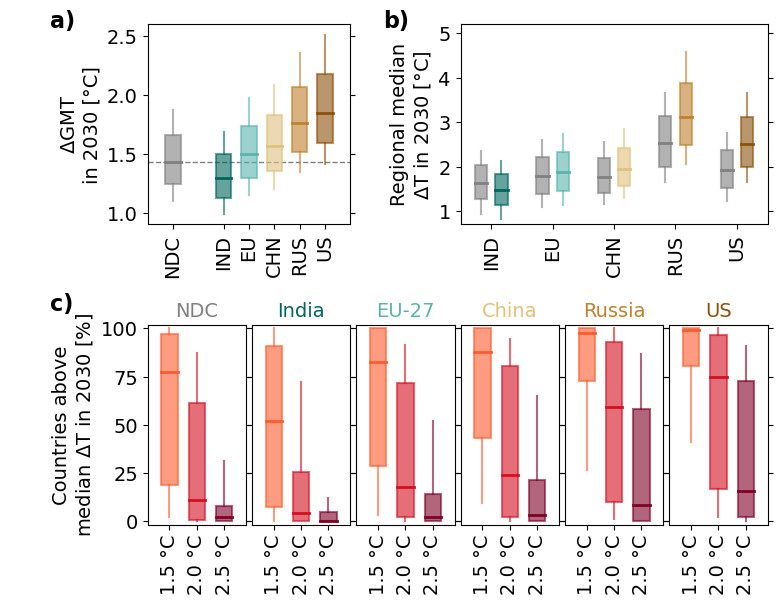

<IPython.core.display.Javascript object>

In [26]:
period = 'Paris'

plt.figure(figsize=(8, 6.5))
plt.rcParams.update({'mathtext.default':'regular'}) #'regular'
plt.rcParams.update({'font.size':14})
fs_let=16
grid = plt.GridSpec(2, 6, wspace=0.06, hspace=0.5) # create a grid for the subplots

# global forced warming
j=0
ax = plt.subplot(grid[0,:2])
plt.axhline(perc_Tglob_gt['h-NDC'][50][-1],color='grey',lw=1,linestyle='--')

boxes = [fill_box(perc_Tglob_gt['h-NDC'],'NDC')]
plot_boxes_glob(boxes,'grey',period)
j+=0.5
for e in emitters:
    boxes = [fill_box(perc_Tglob_gt['pc_'+e+'_'+period],e)]
    plot_boxes_glob(boxes,col[e],period)
    j+=0.25

plt.xlim([-0.25,1.75])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel("$\Delta$GMT\nin 2030 [°C]")

# Regional median warming
ax = plt.subplot(grid[0,3:])

j=0
for e in emitters:
    boxes = [fill_box(reg_T['h-NDC'][e],'')]
    plot_boxes_reg(boxes,'grey',period)
    j+=0.25
    boxes = [fill_box(reg_T['pc_'+e+'_'+period][e],'')]
    plot_boxes_reg(boxes,col[e],period)    
    j+=0.5
    
plt.xticks(np.arange(0.125,3.2,0.75),emitters,rotation='vertical')

plt.xlim([-0.25,3.5])
ax.yaxis.set_ticks_position('both')

ax.set_ylabel("Regional median\n$\Delta$T in 2030 [°C]")


# % countries above threshold
ax = plt.subplot(grid[1,0])

j =0
for thres in thres_levels_median_wi:
    boxes = [fill_box(pct_median_c_over[thres]['h-NDC'],lab_thres_median[thres])]
    plot_boxes_nrc(boxes,mymap_median(norm_median(thres)))
    j+=0.25
ax.set_ylabel("Countries above\nmedian $\Delta$T in 2030 [%]") 
plt.xlim([-0.2,0.7])
ax.yaxis.set_ticks_position('both')

plt.title('NDC',color='grey',fontsize=14)


for i in np.arange(len(emitters)):
    e=emitters[i]
    ax = plt.subplot(grid[1,i+1])
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  
    j =0
    for thres in thres_levels_median_wi:
        boxes=[fill_box(pct_median_c_over[thres]['pc_'+e+'_'+period],lab_thres_median[thres])]
        plot_boxes_nrc(boxes,mymap_median(norm_median(thres)))
        j+=0.25
    plt.xlim([-0.2,0.7])
    plt.title(title_e[i],color=col[e],fontsize=14)

    ax.yaxis.set_ticks_position('both')
    
    
plt.axes([-0.047, 0.825, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'a)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.axes([0.37, 0.825, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'b)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

plt.axes([-0.047, 0.39, 0.05, 0.05]) #[left, bottom, width, height].
plt.text(1,1,'c)',fontsize=fs_let,fontweight='bold')
plt.axis('off')

if period=='Paris':
    plt.savefig(dir_plots+'median_whatif_pc_since_'+period+'.png',dpi=200 ,bbox_inches='tight')
    plt.savefig(dir_plots+'median_whatif_pc_since_'+period+'_beforecrop.pdf',dpi=200 ,bbox_inches='tight')
elif period=='IPCC':
    plt.savefig(dir_plots+'si/median_whatif_pc_since_'+period+'.png',dpi=200 ,bbox_inches='tight')
    plt.savefig(dir_plots+'si/median_whatif_pc_since_'+period+'_beforecrop.pdf',dpi=200 ,bbox_inches='tight')


In [27]:
e ='IND'
period='Paris'
thres = 2

print('expected forced global warming by 2030 under per cap scenario:',perc_Tglob_gt['pc_'+e+'_'+period][50][-1])
print('66% likely range:',perc_Tglob_gt['pc_'+e+'_'+period][17][-1],perc_Tglob_gt['pc_'+e+'_'+period][83][-1])
print('expected forced global warming by 2030 under NDC:',perc_Tglob_gt['h-NDC'][50][-1])
print('66% likely range:',perc_Tglob_gt['h-NDC'][17][-1],perc_Tglob_gt['h-NDC'][83][-1])


print('expected forced regional warming by 2030 under per cap scenario:',reg_T['pc_'+e+'_'+period][e][50][-1])
print('66% likely range:',reg_T['pc_'+e+'_'+period][e][17][-1],reg_T['pc_'+e+'_'+period][e][83][-1])
print('expected forced regional warming by 2030 under NDC:',reg_T['h-NDC'][e][50][-1])
print('66% likely range:',reg_T['h-NDC'][e][17][-1],reg_T['h-NDC'][e][83][-1])


print('expected #countries over by 2030 under per cap scenario:',pct_median_c_over[thres]['pc_'+e+'_'+period][50][-1])
print('66% likely range:',pct_median_c_over[thres]['pc_'+e+'_'+period][17][-1],pct_median_c_over[thres]['pc_'+e+'_'+period][83][-1])
print('expected forced regional warming by 2030 under NDC:',pct_median_c_over[thres]['h-NDC'][50][-1])
print('66% likely range:',pct_median_c_over[thres]['h-NDC'][17][-1],pct_median_c_over[thres]['h-NDC'][83][-1])


expected forced global warming by 2030 under per cap scenario: 1.2981476187705994
66% likely range: 1.1287590432167054 1.4990349197387693
expected forced global warming by 2030 under NDC: 1.433189570903778
66% likely range: 1.2457341349124909 1.663514199256897
expected forced regional warming by 2030 under per cap scenario: 1.484082491601585
66% likely range: 1.1403760103428024 1.8404405032345643
expected forced regional warming by 2030 under NDC: 1.638622515824096
66% likely range: 1.2680945701626047 2.0302950657938745
expected #countries over by 2030 under per cap scenario: 4.242424242424243
66% likely range: 0.0 25.454545454545453
expected forced regional warming by 2030 under NDC: 10.909090909090908
66% likely range: 0.6060606060606061 61.212121212121204


<IPython.core.display.Javascript object>

## Supporting Information Figures

### Figures S2 and S4

Plot Kyoto greenhouse gas emissions


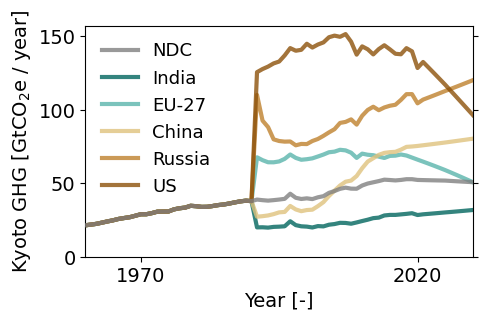

<IPython.core.display.Javascript object>

In [28]:
print("Plot Kyoto greenhouse gas emissions")

period = "IPCC"

idx_t = np.where(time == 1960)[0][0]

fig = plt.figure(figsize=(5, 3))
plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"mathtext.default": "regular"})
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.0)
plt.subplot(grid[0, 0])

plt.plot(
    time[idx_t:],
    KYGHGem["h-NDC"][idx_t:],
    color="grey",
    lw=3,
    alpha=0.8,
    zorder=100,
    label="NDC",
)

for i, e in enumerate(emitters):
    plt.plot(
        time[idx_t:],
        KYGHGem["pc_" + e + "_" + period][idx_t:],
        color=col[e],
        lw=3,
        alpha=0.8,
        label=title_e[i],
    )


ax = plt.gca()
ax.tick_params(right=True)
plt.xticks(np.arange(1870, 2040, 50))
plt.xlim([time[idx_t], time[-1]])
plt.ylim([0, 157])
plt.xlabel("Year [-]")
plt.ylabel("Kyoto GHG [GtCO$_2$e / year]")
plt.legend(fontsize=13, frameon=False)

plt.savefig(
    dir_plots + "si/ts_KYOTOGHGem_pc_" + period + ".png", dpi=200, bbox_inches="tight"
)
plt.savefig(
    dir_plots + "si/ts_KYOTOGHGem_pc_" + period + ".pdf", dpi=200, bbox_inches="tight"
)

### Figure S1

In [29]:
print("Load in the observations")
tblend_g_obs = {}
GMST_obs = {}
time_obs = {}
targ_obs = "tblend"
prods = ["best"]
for prod in prods:
    tblend_g_obs[prod], GMST_obs[prod], time_obs = load_obs(
        targ_obs, prod, lon, lat, cfg, sel_ref="native", ignore_nans=False
    )

tblend_obs, reg_dict, ls = extract_land(
    tblend_g_obs, reg_dict, wgt_g, ls, threshold_land=cfg.threshold_land
)

tblend_obs_nonan = np.nan_to_num(tblend_obs["best"]["obs"])
print("Load in the sample emulations")
sample_emus = joblib.load(dir_samples + "sample_emus.pkl")

Load in the observations
Load in the sample emulations


<IPython.core.display.Javascript object>

In [30]:
print('Compute regional averages of observations, individual sample emulations, and median warming')
reg_obs = {}
reg_sample_emus = {}
reg_perc_median = {}
for e in emitters:

    reg_obs[e]=np.squeeze(np.average(tblend_obs['best']['obs'],weights=wgt_gps_l[e],axis=2))
    # issue: every point in time with any nans on land is set to nan in reg avg

    # workaround: check for each of these time steps if any data point missing in territory of emitter
    # -> if not, use obs with 0 instead of nans -> compute regional average based on this
    nr_ts_nans=np.isnan(reg_obs[e]).sum()
    for i in np.arange(nr_ts_nans):
        if np.isnan(np.squeeze(tblend_obs['best']['obs'])[i,(wgt_gps_l[e]>0)]).sum()==0:
            reg_obs[e][i] = np.average(np.squeeze(tblend_obs_nonan)[i],weights=wgt_gps_l[e])

    reg_sample_emus[e] = np.average(sample_emus,weights=wgt_gps_l[e],axis=2)
    reg_perc_median[e] = np.average(perc_median['h-NDC'][50],weights=wgt_gps_l[e],axis=1)
    


Compute regional averages of observations, individual sample emulations, and median warming


<IPython.core.display.Javascript object>

Plot qualitative evaluation w.r.t. observations


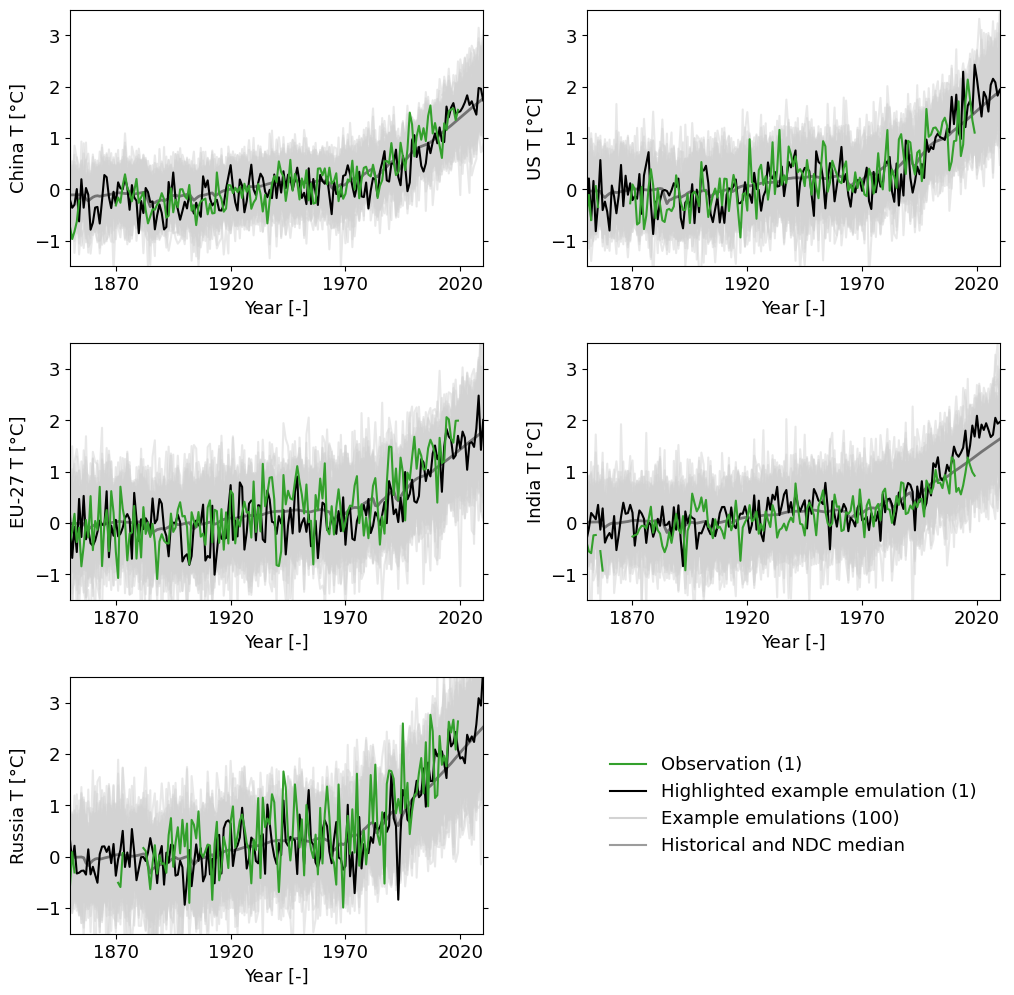

<IPython.core.display.Javascript object>

In [31]:
print("Plot qualitative evaluation w.r.t. observations")

emitters_si = ['CHN','US','EU','IND','RUS'] # ordered by absolute size of emitter
title_e_si = ['China','US','EU-27','India', 'Russia']

n_col = 2
n_row = 3


fig=plt.figure(figsize=(n_col*6., n_row*4))


idx_sample= 222 

k = 0
for i in np.arange(3):
    for j in np.arange(2):
        if k<=4:
            e=emitters_si[k]
            plt.rcParams.update({'font.size': 13})
            plt.rcParams.update({'mathtext.default':'it'}) #regular 

            grid = plt.GridSpec(n_row, n_col, wspace=0.25, hspace=0.3) # create a grid for the subplots

            plt.subplot(grid[i,j])


            for s in np.arange(3,600,6): #samples 100 ESM runs
                plt.plot(time,reg_sample_emus[e][s],color='lightgrey',alpha=0.5,zorder=-100)

            plt.plot(time,reg_perc_median[e],color='#737373',lw=2)

            plt.plot(time,reg_sample_emus[e][idx_sample],color='k')

            # plot obs on pi baseline too
            idx_best=np.logical_and(time>=1951,time<=1980) 
                # offest the median estimate of the emus to shift obs to pi baseline period without 
                # needing to rely on the spatially incomplete obs with lower quality of pi period
            plt.plot(time_obs,reg_obs[e]+np.mean(reg_perc_median[e][idx_best]),color='#33a02c') 


            ax=plt.gca()
            ax.tick_params(right=True)
            plt.xticks(np.arange(1870,2040,50))
            plt.yticks(np.arange(-1,3.2,1))
            plt.xlim([time[0],time[-1]])
            plt.ylim([-1.5,3.5])
            plt.xlabel('Year [-]')
            plt.ylabel(title_e_si[k]+' T [°C]')
            k+=1
            
        else:
            plt.subplot(grid[i,j])

            custom_lines = [Line2D([0], [0], color='#33a02c',alpha=1),
                Line2D([0], [0],color='k'),
                Line2D([0], [0],color='lightgrey'),
                Line2D([0], [0],color='#737373',alpha=0.7)] 
            plt.legend(custom_lines, ['Observation (1)','Highlighted example emulation (1)','Example emulations (100)','Historical and NDC median'],loc='center',frameon=False)
            plt.axis('off')

    


plt.savefig(dir_plots+'si/ts_top5_emus_obs_sample'+str(idx_sample)+'_samples_median.png' ,dpi=200 ,bbox_inches='tight')
plt.savefig(dir_plots+'si/ts_top5_emus_obs_sample'+str(idx_sample)+'_samples_median.pdf' ,dpi=200 ,bbox_inches='tight')
